## LD2L data project

#### Introduction

In order to pull interesting data from ld2l.gg I have created a basic set of pulls to gather match data and parse it into a dataframe. 
This dataframe is exported to a csv and can be used with any BI software or can be read programatiicaly with dataframe packages for exploration

In [1]:
#import 

import pandas as pd
import numpy as np
import requests
import json
import bs4
import time
import os

# You will need your own API key from opendota 
# and a config.py file that sets the variable api_key to your key
from config import api_key

In [2]:
# display full dataframe
pd.set_option('display.max_columns', None)

#### Pulling season info

Basic match data is found on ld2l.gg/seasons/##/matches. My outline here will use season 37 for prototyping. 

Using BeautifulSoup (BS) (https://www.crummy.com/software/BeautifulSoup/bs4/doc/) the ld2l matches page is parsed to get the ld2l match id. 
The ld2l match id does not match the dota match id

A cache file is created, unless it already exists, to avoid re-parsing saved info.

Note that seasons on the website do not relate to the ticket or season that would be listed in Dota/OpenDota api.
This method also reduces adding in matches that ticket holders use for scrims or other reasons that aren't official games.
One limitation is that this method can't pull unticketed data, even if entered in completly on the ld2l website.



In [3]:
#set ld2l season webpage

#prototype will be for season 37, the function will be for any season via input
season = 37

url = f'https://ld2l.gg/seasons/{season}/matches'


soup = bs4.BeautifulSoup(requests.get(url).text, 'html.parser')
matches = []

# This is a directory string to help manage the data of different seasons
save_dir = f'match_data_{season}'

for a in soup.find_all('a', href=True):
    if 'match' in a['href'] and 'season' not in a['href']:
        matches.append('https://ld2l.gg' + a['href'])

#sort matches by ID
matches.sort(key=lambda x: int(x.split('/')[-1]))

# create a folder to store match data if it doesn't exist
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# matches text file location to variable
matches_file = f'{save_dir}/matches_{season}.txt'

# create a matches text file to store match IDs if it doesn't exist

if not os.path.exists(matches_file):
    with open(matches_file, 'w') as f:
        f.write('')

print(f'Found {len(matches)} matches in season {season} \nfile location: {matches_file}')


Found 60 matches in season 37 
file location: match_data_37/matches_37.txt


#### Converting to OpenDota links

After gathering the match data, each match page is opened via BS. From here the Match ID is extracted from the 
OpenDota link and a correctly formatted OpenDota API link is added to a list.

This section skips over matches that have been parsed already by checking the matches.txt file created in the last secion

In [4]:
# below code writes match IDs to file if they are not already in the file

with open(matches_file) as f:
    data = f.read()

for match in matches:
    #check if match is already in file matches.txt to prevent re-scraping and angry butterygreg
    if match not in data:
        #write match to file
        with open(matches_file, 'a') as f:
            f.write(match + '\n')


In [5]:
# add openDota link for each match

#read matches.txt into list
with open(matches_file) as f:
    data = f.read().split('\n')
    #remove empty string from list
    if data[-1] == '':
        data.pop()

# parse each match link via bs to get openDota link

opendota = []

for match in data:
    soup = bs4.BeautifulSoup(requests.get(match).text, 'html.parser')
    for a in soup.find_all('a', href=True):
        if 'opendota' in a['href'] and 'matches/0' not in a['href']:
            match_link = a['href']
            opendota.append(match_link)
            break

# convert opendota links to API links

opendota_api = []

for match in opendota:
    match_id = match.split('/')[-1]
    api_link = f'https://api.opendota.com/api/matches/{match_id}?api_key={api_key}'
    opendota_api.append(api_link)

#### Pulling OpenDota Jsons

In [6]:
# hold list of file names
file_names = []

for files in os.listdir(save_dir):
    if files.endswith('.json'):
        file_names.append(files)

for match in opendota_api:

    # get match id
    match_id = match.split('/')[-1].split('?')[0]

    file_path = f'{save_dir}/match_{match_id}.json'

    #check if file already exists
    if not os.path.isfile(f'{file_path}'):
        # get json of match and save to json file
        match_json = requests.get(match).json()
        with open(f'{save_dir}/match_{match_id}.json', 'w') as f:
            json.dump(match_json, f)
            file_names.append(f'match_{match_id}.json')

In [7]:
file_names

['match_6982868616.json',
 'match_6982904807.json',
 'match_6982867622.json',
 'match_6982934817.json',
 'match_6982884342.json',
 'match_6982931651.json',
 'match_6982877034.json',
 'match_6982940646.json',
 'match_6982865709.json',
 'match_6982900159.json',
 'match_6982866447.json',
 'match_6982907814.json',
 'match_6993385502.json',
 'match_6993431932.json',
 'match_6993383257.json',
 'match_6993447694.json',
 'match_6993392642.json',
 'match_6993438994.json',
 'match_6993380342.json',
 'match_6993431150.json',
 'match_6993387493.json',
 'match_6993433983.json',
 'match_6993383916.json',
 'match_6993429451.json',
 'match_7004155202.json',
 'match_7004196123.json',
 'match_7004140570.json',
 'match_7004206771.json',
 'match_7004160100.json',
 'match_7004210195.json',
 'match_7004159214.json',
 'match_7004203614.json',
 'match_7004155925.json',
 'match_7004203500.json',
 'match_7004149439.json',
 'match_7004199027.json',
 'match_7025177090.json',
 'match_7025219912.json',
 'match_7025

#### DataFrame formatting and basic cleaning

Below a blank dataframe is created with the selected features from the players section in the read json files. 
As with earlier sections, if a cached match_data.csv exists, new items will be concatenated instead of a new creations, saving time and resources.

#### If the data is not been parsed on opendota by requesting, the below will not function properly

In [8]:
# create an empty dataframe to hold all match data if it doesn't exist

# csv file location to variable

csv_file = f'{save_dir}/match_data_{season}.csv'

if not os.path.exists(csv_file):
    match_data = pd.DataFrame(columns=['match_id', 'date', 'week', 'account_id', 'personaname', 'teamID', 'rank_tier', 'kills', 'assists',
       'deaths', 'kills_per_min', 'kda', 'denies', 'gold', 'gold_per_min', 'gold_spent', 'hero_damage', 'damage_taken',
       'hero_healing', 'hero_id', 'item_0', 'item_1', 'item_2', 'item_3',
       'item_4', 'item_5', 'item_neutral', 'last_hits', 'level',
       'net_worth', 'tower_damage', 'xp_per_min', 'radiant_win',
       'duration', 'patch', 'isRadiant', 'win', 'lose',
       'total_gold', 'total_xp', 'obs_placed', 'sen_placed', 'rune_pickups', 'camps_stacked', 'stuns', 'creeps_stacked',
       'firstblood_claimed', 'pings', 'teamfight_participation', 'roshans_killed'])
    match_data.to_csv(csv_file, index=False)
else:
    match_data = pd.read_csv(csv_file, index_col=None)

In [9]:
# heroes are stored as IDs isntead of names. A new api call is needed to get the hero names. This will be stored in a dataframe

#check if hero names csv file exists
if not os.path.exists('hero_names.csv'):
    heroes = requests.get(f'https://api.opendota.com/api/heroes?{api_key}').json()
    heroes_df = pd.DataFrame(heroes)
    heroes_df.to_csv('hero_names.csv', index=False)
else:
    heroes_df = pd.read_csv('hero_names.csv')

heroes_df.head()

,id,name,localized_name,primary_attr,attack_type,roles,legs
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"['Carry', 'Escape', 'Nuker']",2
1,2,npc_dota_hero_axe,Axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Jungler'...",2
2,3,npc_dota_hero_bane,Bane,int,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",4
3,4,npc_dota_hero_bloodseeker,Bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Jungler', 'Nuker', 'Ini...",2
4,5,npc_dota_hero_crystal_maiden,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker', 'Jungler']",2


In [10]:
for  i, file in enumerate(file_names):

    print(f'{save_dir}/{file}')
    
    # read first json file as a dictionary
    with open(f'{save_dir}/{file}') as f:
        data = json.load(f)

    # get match id
    match_id = data['match_id']

    # if match id is already in matches_df, skip
    if match_id in match_data['match_id'].values:
        pass
    else:

        # check to see if match is valid

        rad_team_id = data['radiant_team_id']
        dire_team_id = data['dire_team_id']
        
        # read player from data into a dataframe

        df = pd.DataFrame(data['players'])

        #convert start_time from unix time to datetime using
        df['start_time'] = pd.to_datetime(df['start_time'], unit='s')
        df['date'] = df['start_time'].dt.date

        #games are played weekly. the min week is 1 and each subsequent week
        df['week'] = df['start_time'].dt.isocalendar().week - df['start_time'].dt.isocalendar().week.min() + 1


        #drop start_time
        df.drop('start_time', axis=1, inplace=True)

        # if isRadiant is true, set teamID to radiant team ID, else set to dire team ID

        df['teamID'] = df['isRadiant'].apply(lambda x: rad_team_id if x == True else dire_team_id)

        # damage_taken is a nested dictionary. We want the sum of the values in the dictionary. if damage_taken is empty, set to 0
        df['damage_taken'] = df['damage_taken'].apply(lambda x: sum(x.values()) if x else 0)


        new_order = match_data.columns.tolist()

        df = df[new_order]

        #replace hero_id with hero name from heroes_df
        df['hero_id'] = df['hero_id'].map(heroes_df.set_index('id')['localized_name'])

        # append to main df via concat

        match_data = pd.concat([match_data, df], axis=0)

        # replace NaN with 0
        match_data.fillna(0, inplace=True)

        # save to csv every loop
        match_data.to_csv(csv_file, index=False)

match_data_37/match_6982868616.json
match_data_37/match_6982904807.json
match_data_37/match_6982867622.json
match_data_37/match_6982934817.json
match_data_37/match_6982884342.json
match_data_37/match_6982931651.json
match_data_37/match_6982877034.json
match_data_37/match_6982940646.json
match_data_37/match_6982865709.json
match_data_37/match_6982900159.json
match_data_37/match_6982866447.json
match_data_37/match_6982907814.json
match_data_37/match_6993385502.json
match_data_37/match_6993431932.json
match_data_37/match_6993383257.json
match_data_37/match_6993447694.json
match_data_37/match_6993392642.json
match_data_37/match_6993438994.json
match_data_37/match_6993380342.json
match_data_37/match_6993431150.json
match_data_37/match_6993387493.json
match_data_37/match_6993433983.json
match_data_37/match_6993383916.json
match_data_37/match_6993429451.json
match_data_37/match_7004155202.json
match_data_37/match_7004196123.json
match_data_37/match_7004140570.json
match_data_37/match_70042067

#### Preview

Below will be a dataframe preview. Please note that some assumptions may cause the wrong week to display.

In [11]:
match_data.head()

,match_id,date,week,account_id,personaname,teamID,rank_tier,kills,assists,deaths,kills_per_min,kda,denies,gold,gold_per_min,gold_spent,hero_damage,damage_taken,hero_healing,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,item_neutral,last_hits,level,net_worth,tower_damage,xp_per_min,radiant_win,duration,patch,isRadiant,win,lose,total_gold,total_xp,obs_placed,sen_placed,rune_pickups,camps_stacked,stuns,creeps_stacked,firstblood_claimed,pings,teamfight_participation,roshans_killed
0,6982868616,2023-01-22,1,262007292,✪︎_DArK AcE ™,8975282,33,3,12,3,0.10632,3,9,2133,232,4900,9099,7910,0,Vengeful Spirit,29,232,0,188,216,0,0,3,12,6423,460,310,True,1693,51,True,1,0,6546,8747,3,5,2,0,44.795105,0,0,32.0,0.517241,0
1,6982868616,2023-01-22,1,221828374,Bluejay,8975282,41,9,11,0,0.31896,20,8,1954,513,13525,15614,13582,0,Riki,75,63,147,174,143,117,212,144,17,14484,4373,597,True,1693,51,True,1,0,14475,16845,0,0,0,0,1.505127,0,0,5.0,0.689655,0
2,6982868616,2023-01-22,1,50731640,Molski,8975282,15,2,9,2,0.07088,3,0,945,280,7525,7552,12663,0,Jakiro,100,36,218,180,188,0,306,36,13,7170,2582,367,True,1693,51,True,1,0,7900,10355,6,12,2,1,30.620312,2,0,0.0,0.344828,0
3,6982868616,2023-01-22,1,303581431,Push-Up Nutter,8975282,52,5,10,0,0.17720,15,30,2419,528,13420,11636,18975,5200,Underlord,231,226,206,0,34,73,945,192,16,14824,3843,545,True,1693,51,True,1,0,14898,15378,0,0,1,0,72.729980,0,0,19.0,0.517241,0
4,6982868616,2023-01-22,1,930087419,PeePeeEm,8975282,55,10,11,0,0.35440,21,22,4322,562,12475,32001,10378,110,Silencer,263,77,41,534,63,36,349,158,17,16022,7148,618,True,1693,51,True,1,0,15857,17437,2,0,14,0,0.000000,0,0,15.0,0.724138,1


### Analysis

In order to understand what types of tests are appropriate, a few visualizations will be done at the player level and team level. Future analysis may also want to group and run by map side, match and [map_side, match]

In [12]:
from matplotlib import pyplot as plt
from scipy.stats import norm
import statistics

#magic word for producing visualizations in notebook
%matplotlib inline

In [13]:
# functionize aggregation plots
def plot_hist_aggs(feature):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    # unaggregated
    x = match_data[feature]

    axes[0].hist(x, label=feature, bins=20, alpha=0.5)
    axes[0].legend()
    axes[0].set_title(f'{feature} Histogram')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Count')
    if abs(x.mean() - x.median()) > .05:
        axes[0].axvline(x.mean(), color='b', linestyle='dashed', linewidth=3, label='mean')
        axes[0].axvline(x.median(), color='r', linestyle='dashed', linewidth=3, label='median')
        
    else:
        axes[0].axvline(x.mean(), color='black', linestyle='dashed', linewidth=3, label='mean and median')

   

    # aggregated by player

    x_player = match_data.groupby('account_id')[feature].mean()

    axes[1].hist(x_player, label=feature, bins=20, alpha=0.5)
    axes[1].legend()
    axes[1].set_title(f'{feature} Histogram: Player agg')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel('Count')
    if abs(x_player.mean() - x_player.mean()) > .05:
        axes[1].axvline(x_player.mean(), color='b', linestyle='dashed', linewidth=3, label='mean')
        axes[1].axvline(x_player.median(), color='r', linestyle='dashed', linewidth=3, label='median')
    else:
        axes[1].axvline(x_player.mean(), color='black', linestyle='dashed', linewidth=3, label='mean and median')

    # aggregated by team
    
    x_team = match_data.groupby('teamID')[feature].mean()

    axes[2].hist(x_team, label=feature, bins=20, alpha=0.5)
    axes[2].legend()
    axes[2].set_title(f'{feature} Histogram: Team agg')
    axes[2].set_xlabel(feature)
    axes[2].set_ylabel('Count')
    if abs(x_team.mean() - x_team.mean()) > .05:
        axes[2].axvline(x_team.mean(), color='b', linestyle='dashed', linewidth=3, label='mean')
        axes[2].axvline(x_team.median(), color='r', linestyle='dashed', linewidth=3, label='median')
    else:
        axes[2].axvline(x_team.mean(), color='black', linestyle='dashed', linewidth=3, label='mean and median')
        
    plt.show()

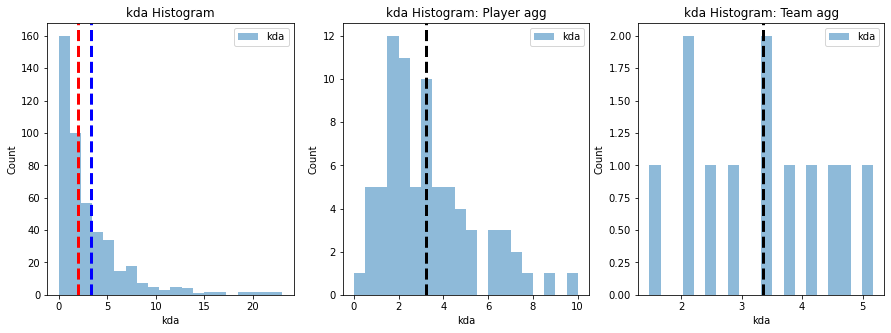

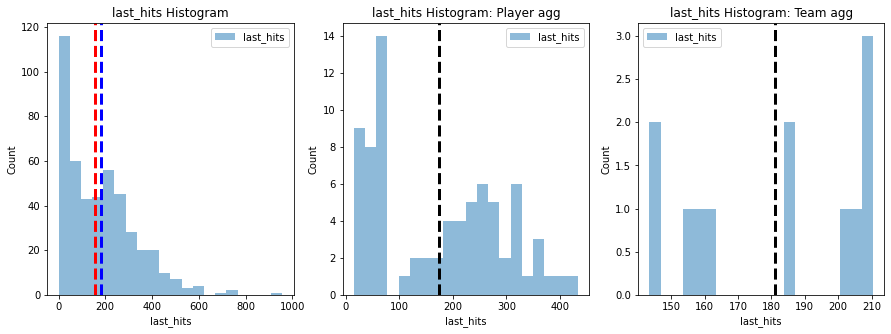

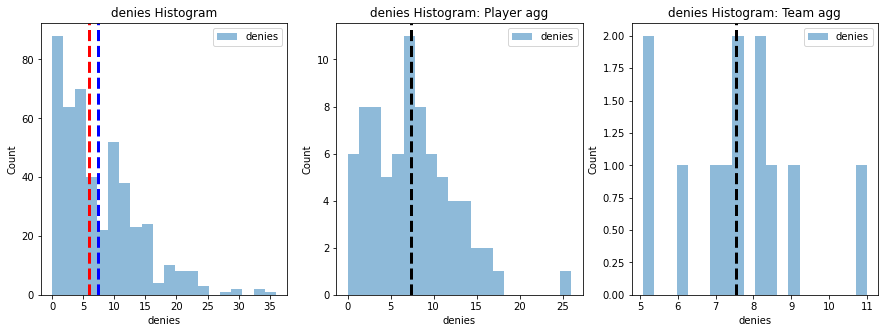

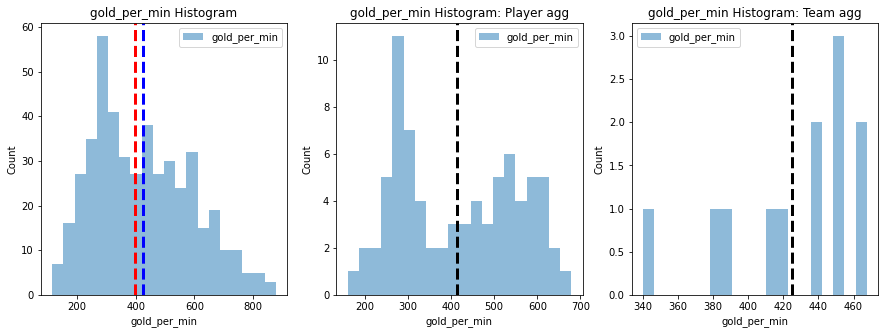

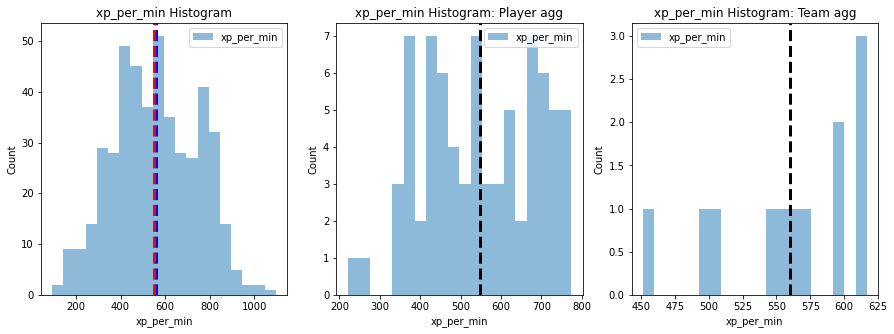

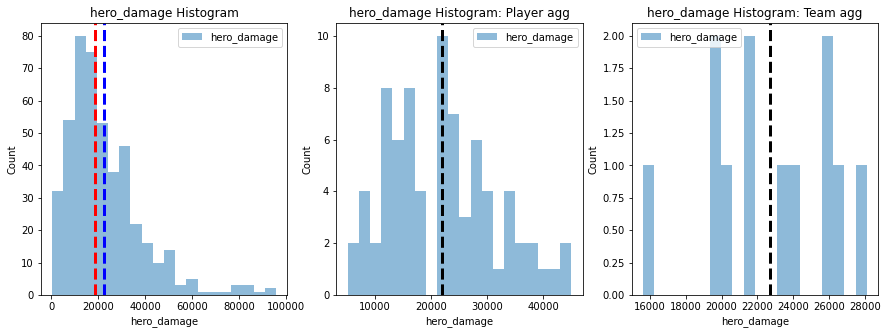

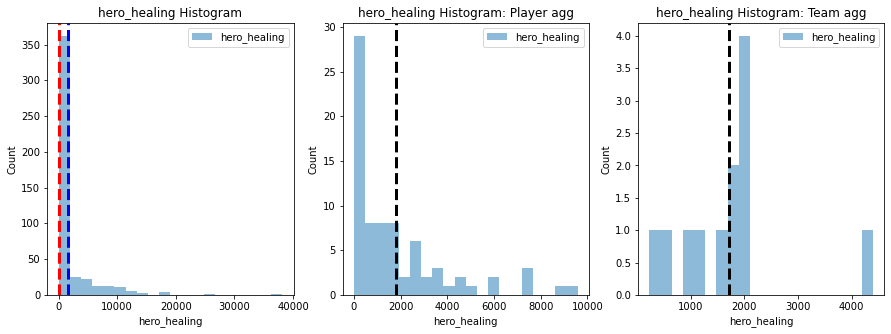

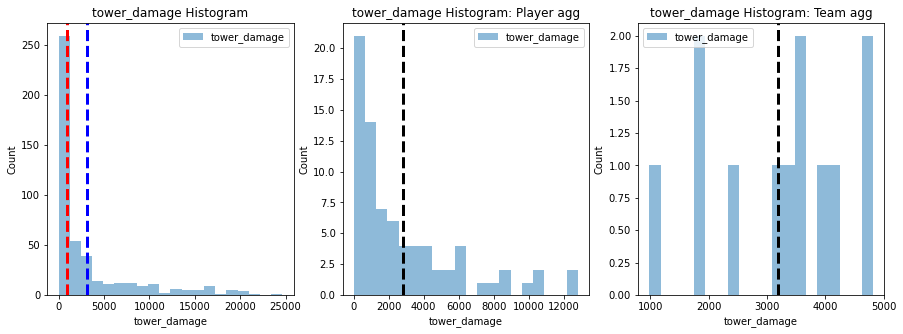

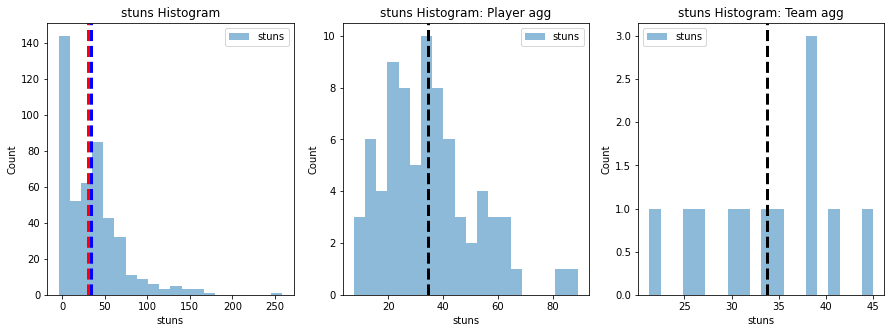

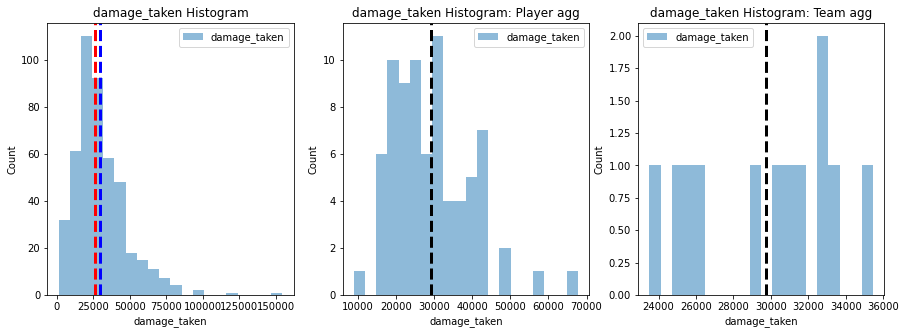

In [14]:
game_stats = ['kda', 'last_hits', 'denies', 'gold_per_min', 'xp_per_min', 'hero_damage', 'hero_healing', 'tower_damage', 'stuns', 'damage_taken']

for stat in game_stats:
    plot_hist_aggs(stat)